# Note:

    Main idea is to increase ROC-AUC score more than 0.8 and F1 > 80%

# Import libraries

In [1]:
import os, sys
import pickle

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import DataLoader, Dataset
import torch

from scipy.stats import ttest_ind
from scipy.stats import ttest_1samp
from sklearn.metrics import accuracy_score

# Import Data

In [2]:
# df_users = pd.read_parquet('df_users_embedings.parquet')
# df_posts = pd.read_parquet('df_posts_new_features.parquet')
# df_target_0 = pd.read_parquet('df_target_0.parquet')
# df_target_1 = pd.read_parquet('df_target_1.parquet')
# df = pd.read_parquet("million_rows_raw_embedings.parquet")
df = pd.read_parquet("million_rows_new_features_raw.parquet")

## Concat All Data In one DataFrame

In [5]:
# def concat_df(df_users: pd.DataFrame, df_posts: pd.DataFrame, df_to_concat: pd.DataFrame) -> pd.DataFrame:
#     df = df_to_concat.merge(df_posts, how='inner', on='post_id').merge(df_users, how='inner', left_on='user_id', right_on='id')
#     df = df.drop(axis=1, columns=["id", "user_id", "post_id", "action"])
#     df = df.rename(columns={'timestamp':'time'})
#     return df

# df_concat_0 = concat_df(df_users, df_posts, df_target_0)
# df_concat_1 = concat_df(df_users, df_posts, df_target_1)
# df = pd.concat([df_concat_0, df_concat_1])

In [6]:
# df.to_parquet("million_rows_new_features_raw.parquet")

# Prepaire dataset

In [8]:
class CustomImageDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        data = self.df.loc[idx]
        target_label = data.iloc[1]
        data_of_intersting = data.iloc[2:]
        return torch.Tensor(data_of_intersting).unsqueeze(0), torch.Tensor([target_label])

In [9]:
index_train = df.sample(frac=0.7, random_state=2009).index.to_list()

In [10]:
df_train = df[df.index.isin(index_train)].reset_index(drop=True)
df_test = df[~df.index.isin(index_train)].reset_index(drop=True)

### Look At Target split

In [11]:
# target_mean_after = [df_test.target.sample(1000).mean() for i in range(10000)]

In [12]:
# target_mean_before = [df_train.target.sample(1000).mean() for i in range(10000)]

In [13]:
# ttest_ind(target_mean_after, target_mean_before)

## Load Custom Torch Dataset

In [14]:
test_data = CustomImageDataset(df=df_test)
train_data = CustomImageDataset(df=df_train)

In [50]:
df_test.columns.to_list()

['time',
 'target',
 'topic_covid',
 'topic_entertainment',
 'topic_movie',
 'topic_politics',
 'topic_sport',
 'topic_tech',
 'kmean_label',
 'DistanceToCluster_0',
 'DistanceToCluster_1',
 'DistanceToCluster_2',
 'DistanceToCluster_3',
 'DistanceToCluster_4',
 'DistanceToCluster_5',
 'DistanceToCluster_6',
 'DistanceToCluster_7',
 'DistanceToCluster_8',
 'DistanceToCluster_9',
 'DistanceToCluster_10',
 'DistanceToCluster_11',
 'DistanceToCluster_12',
 'DistanceToCluster_13',
 'DistanceToCluster_14',
 'gender',
 'age',
 'Belarus',
 'Cyprus',
 'Estonia',
 'Finland',
 'Kazakhstan',
 'Latvia',
 'Russia',
 'Switzerland',
 'Turkey',
 'Ukraine',
 'exp_1',
 'exp_2',
 'exp_3',
 'exp_4',
 'Android',
 'iOS',
 'ads',
 'organic']

In [15]:
train_loader = DataLoader(train_data, batch_size=64, pin_memory=True, num_workers=6, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, pin_memory=True, num_workers=6, shuffle=False)

# Load Custom NN model

In [16]:
import torch.nn as nn
import torch

from tqdm import tqdm
from IPython.display import clear_output


from torch.optim import Adam

In [17]:
class ResMLP_3Blocks(nn.Module):
    def __init__(self, in_channels: int = 1, base_size: int = 42 , target_size: int = 1):
        super().__init__()

        self.activation_default = nn.PReLU()

        self.FCNN_down_1 = nn.Sequential(
            nn.Linear(base_size, base_size//2),
            nn.BatchNorm1d(in_channels),
            self.activation_default)

        self.FCNN_1 = nn.Sequential(
            nn.Linear(base_size//2, base_size//2),
            nn.BatchNorm1d(in_channels),
            self.activation_default,
            nn.Dropout(0.4),

            nn.Linear(base_size//2, base_size//2),
            nn.BatchNorm1d(in_channels),
            self.activation_default,
            nn.Dropout(0.4),)

        self.FCNN_down_2 = nn.Sequential(
            nn.Linear(base_size//2, base_size//4),
            nn.BatchNorm1d(in_channels),
            self.activation_default)


        self.FCNN_2 = nn.Sequential(
            nn.Linear(base_size//4, base_size//4),
            nn.BatchNorm1d(in_channels),
            self.activation_default,
            nn.Dropout(0.2),

            nn.Linear(base_size//4, base_size//4),
            nn.BatchNorm1d(in_channels),
            self.activation_default,
            nn.Dropout(0.2),)

        self.FCNN_down_3 = nn.Sequential(
            nn.Linear(base_size//4, base_size//8),
            nn.BatchNorm1d(in_channels),
            self.activation_default,
            nn.Dropout(0.2),)

        self.FCNN_3 = nn.Sequential(
            nn.Linear(base_size//8, base_size//8),
            nn.BatchNorm1d(in_channels),
            self.activation_default,
            nn.Dropout(0.1),

            nn.Linear(base_size//8, base_size//8),
            nn.BatchNorm1d(in_channels),
            self.activation_default,
            nn.Dropout(0.1),)

        self.FCNN_down_4 = nn.Sequential(
            nn.Linear(base_size//8, base_size//16),
            nn.BatchNorm1d(in_channels),
            self.activation_default,)
            
        self.out = nn.Sequential(
            nn.Linear(base_size//16, target_size),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x_1 = self.FCNN_down_1(x)
        x_2 = self.FCNN_1(x_1)
        x_3 = self.FCNN_down_2(x_2+x_1)
        x_4 = self.FCNN_2(x_3)
        x_5 = self.FCNN_down_3(x_4+x_3)
        x_6 = self.FCNN_3(x_5)
        x_7 = self.FCNN_down_4(x_6+x_5)
        return self.out(x_7)

# Define Train and Test functions

In [18]:
from sklearn.metrics import accuracy_score

In [19]:
def train(model):
    model.train()

    train_loss = []
    accuracy = []
    for x, y in tqdm(train_loader, desc='Train'):
        
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        output = model(x).squeeze(1)


        loss = loss_fn(output, y)

        #как ты делишь?!
        # a = y.view(x.shape[0]).detach().to("cpu")
        # b = torch.round(output.view(x.shape[0]).to("cpu")).detach()
        # accuracy += (1-((a - b).sum())/x.shape[0]).item()*100
        a = y.view(x.shape[0]).to("cpu").detach()
        b = torch.round(output.view(x.shape[0])).to("cpu").detach()
        
        accuracy.append(accuracy_score(a, b))
        train_loss.append(loss.detach().item())

        loss.backward()
        optimizer.step()
        
        del loss
        del output

    train_loss = np.mean(train_loss)
    accuracy = np.mean(accuracy)

    return train_loss, accuracy

In [20]:
@torch.inference_mode()
def evaluate(model, loader):
    model.eval()

    total_loss = []
    accuracy = []
    
    for x, y in tqdm(loader, desc='Evaluation'):
        x = x.to(device)
        y = y.to(device)
        output = model(x).squeeze(1)

        loss = loss_fn(output, y)

        a = y.view(x.shape[0]).to("cpu").detach()
        b = torch.round(output.view(x.shape[0])).to("cpu").detach()
        
        accuracy.append(accuracy_score(a, b))
        total_loss.append(loss.detach().item())
        
        # total_loss += loss.detach().item()

        del loss
        del output
        
    total_loss = np.mean(total_loss)
    accuracy = np.mean(accuracy)
    
    return total_loss, accuracy

In [21]:
def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Test loss')
    plt.legend()
    plt.grid()

    plt.show()

In [22]:
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy_loss = train(model)
        valid_loss, valid_accuracy_loss = evaluate(model, test_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy_loss)
        valid_accuracy_history.append(valid_accuracy_loss)

        clear_output(wait=True)

        print(f"Train Accuracy: {train_accuracy_loss} %")
        print(f"Test Accuracy: {valid_accuracy_loss} %")
        plot_stats(
            train_loss_history, valid_loss_history,
            title
        )

In [23]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

loss_fn = nn.BCELoss()
#loss_fn = nn.MSELoss()

cuda:0


In [24]:
model = ResMLP_3Blocks().to(device)
optimizer = Adam(model.parameters(), lr=1e-1)

Train Accuracy: 0.6502516370798588 %
Test Accuracy: 0.649675468591692 %


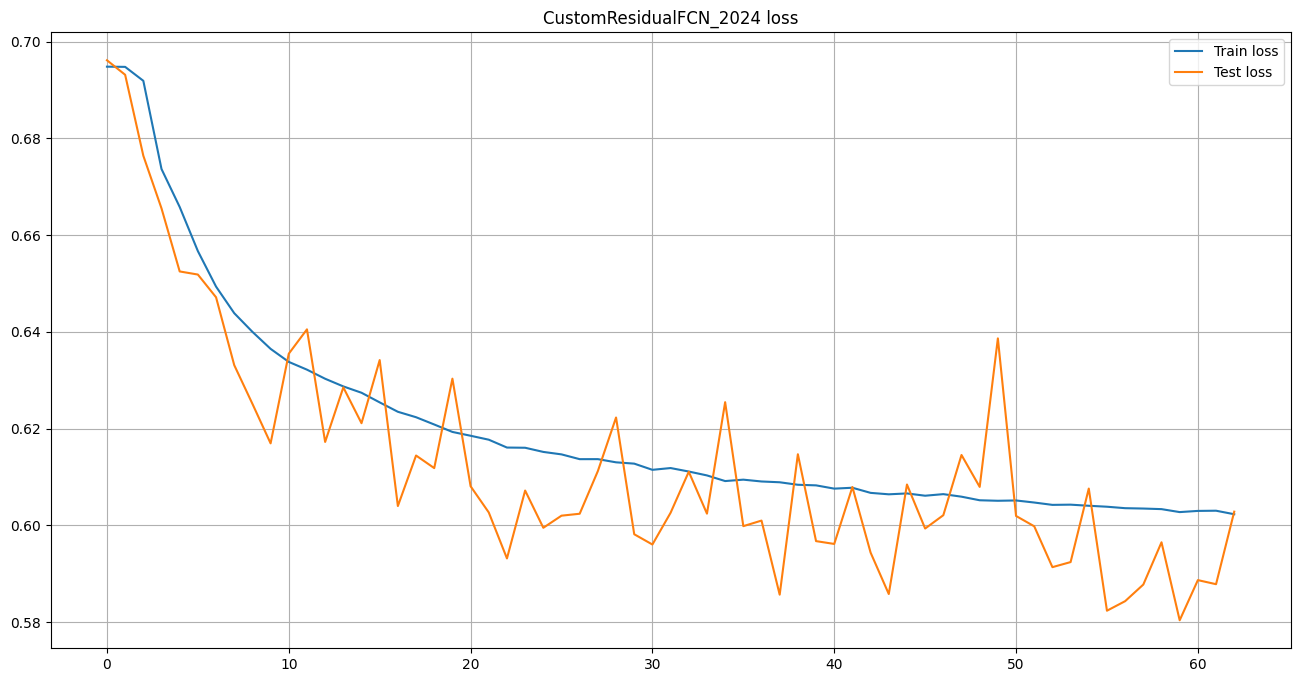

Train:   0%|                                                                                                                           | 0/14216 [00:00<?, ?it/s]/tmp/ipykernel_5022/1619074521.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.Tensor(data_of_intersting).unsqueeze(0), torch.Tensor([target_label])
/tmp/ipykernel_5022/1619074521.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.Tensor(data_of_intersting).unsqueeze(0), torch.Tensor([target_label])
/tmp/ipykernel_5022/1619074521.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future ver

KeyboardInterrupt: 

In [25]:
whole_train_valid_cycle(model, 100, 'CustomResidualFCN_2024')

# Check Model Results

In [26]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

from sklearn import metrics

In [27]:
# model = ResMLP_3Blocks()
# model.load_state_dict(torch.load('CustomResidualFCN_2024'))
# model.eval()

In [28]:
@torch.inference_mode()
def predict(model, loader):
    model.eval()
    

    pred_list = []
    original_list = []
    for x, y in tqdm(loader, desc='Prediction'):
        x = x.to("cuda:0")
        y = y.to("cuda:0")
        
        preds = model(x)

        pred_list.extend(preds.view(x.shape[0]).to("cpu").detach().numpy())
        original_list.extend(y.view(y.shape[0]).to("cpu").detach().numpy())
    return pred_list, original_list

In [29]:
# model = model.to("cuda")

In [30]:
preds, origins = predict(model, test_loader)

Prediction:   0%|                                                                                                                       | 0/1410 [00:00<?, ?it/s]/tmp/ipykernel_5022/1619074521.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.Tensor(data_of_intersting).unsqueeze(0), torch.Tensor([target_label])
/tmp/ipykernel_5022/1619074521.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.Tensor(data_of_intersting).unsqueeze(0), torch.Tensor([target_label])
/tmp/ipykernel_5022/1619074521.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future ver

In [31]:
def round_preds(preds):
    return [round(x) for x in preds]

In [32]:
preds_binary = round_preds(preds)

In [33]:
print(classification_report(origins,preds_binary))

              precision    recall  f1-score   support

         0.0       0.67      0.66      0.66     45109
         1.0       0.66      0.67      0.67     45109

    accuracy                           0.66     90218
   macro avg       0.66      0.66      0.66     90218
weighted avg       0.66      0.66      0.66     90218



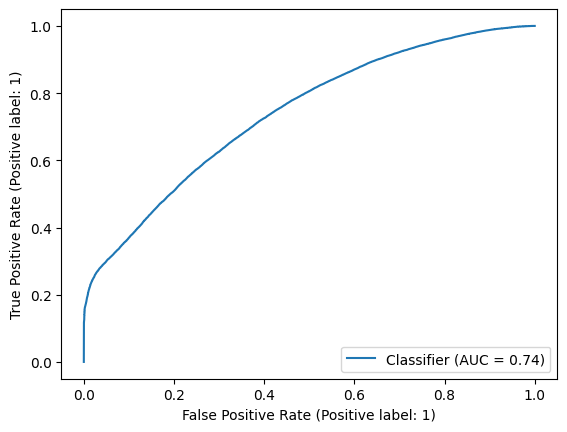

In [34]:
t = metrics.RocCurveDisplay.from_predictions(origins, preds)

In [35]:
fpr, tpr, thresholds = metrics.roc_curve(origins, preds, pos_label=1)

In [36]:
thresholds[16370]

0.51403457

In [37]:
np.where(tpr > 0.8)

(array([25030, 25031, 25032, ..., 37616, 37617, 37618]),)

In [47]:
mean_preds_list = [np.mean(np.random.choice(preds, size=1000).round()) for i in range(10000)]

In [48]:
mean_origin_list = [np.mean(np.random.choice(origins, size=1000).round()) for i in range(10000)]

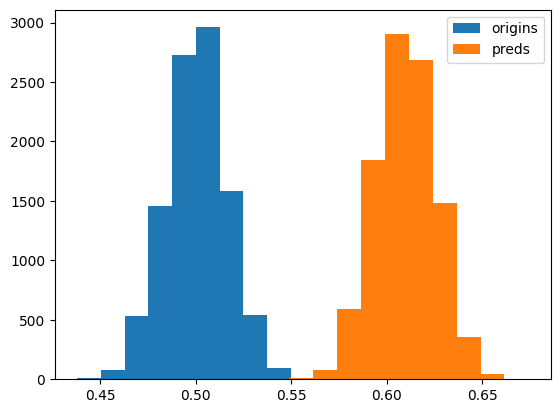

In [49]:
plt.hist(mean_origin_list, label='origins')
plt.hist(mean_preds_list, label='preds')
plt.legend()

In [54]:
ttest_ind(mean_origin_list, mean_preds_list)

TtestResult(statistic=-492.04536459011445, pvalue=0.0, df=19998.0)

In [55]:
np.mean(mean_origin_list)

0.500331

In [56]:
ttest_1samp(mean_preds_list, np.mean(mean_origin_list))

TtestResult(statistic=708.0795932499602, pvalue=0.0, df=9999)

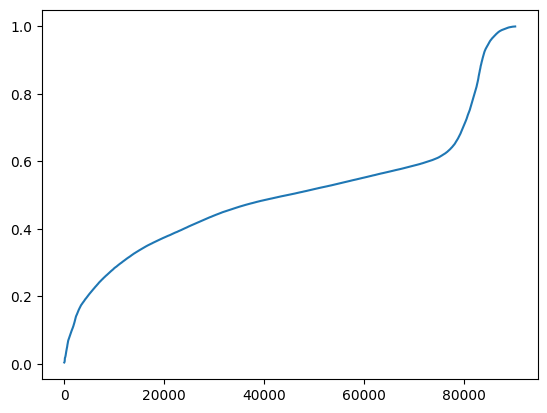

In [38]:
plt.plot(sorted(preds))

## Save model

In [53]:
# # Saving model
# model_scripted = torch.jit.script(model.to("cpu")) # Export to TorchScript
# model_scripted.save("CustomResidualNN_2024_CPU.pth") # Save

# # Loading model
# model = torch.jit.load("CustomResidualNN_2024.pth")
# model.eval()